# HHL in qiskit

Based on [qiskit tutorial](https://qiskit.org/textbook/ch-applications/hhl_tutorial.html).

---

Let's solve a system of linear equations $Ax=b$ in Qiskit. This is easy (joke)!

First, we prepare a circuit of the algorithm. It includes:
- $|b\rangle$ initialization, 
- $QPE$ of $\tilde{A}=e^{iAt}$, 
- eigenvector inversion, 
- and $QPE^\dagger$

In [48]:
import numpy as np

# algorithm
from qiskit.algorithms.linear_solvers.hhl import HHL

# Matrix A
A = np.array([[1, -1/3], [-1/3, 1]])

# vector b
b = np.array([[1, 0]]).T

naive_hhl_solution = HHL().solve(A, b)
naive_hhl_solution.state.draw()

┌─────────────┐┌──────┐        ┌─────────┐
q178_0: ┤ circuit-958 ├┤2     ├────────┤2        ├
        └─────────────┘│      │┌──────┐│         │
q179_0: ───────────────┤0 QPE ├┤1     ├┤0 QPE_dg ├
                       │      ││      ││         │
q179_1: ───────────────┤1     ├┤0 1/x ├┤1        ├
                       └──────┘│      │└─────────┘
q180_0: ───────────────────────┤2     ├───────────
                               └──────┘

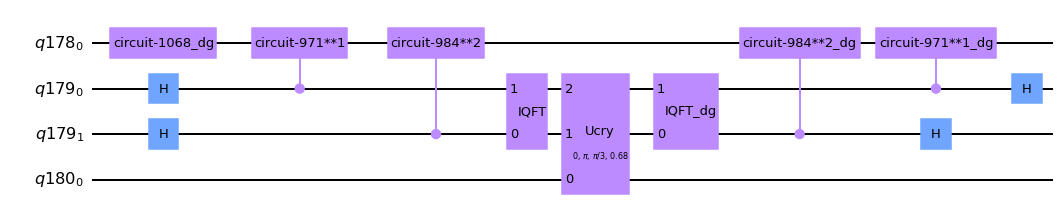

In [49]:
naive_hhl_solution.state.decompose().decompose().draw(output='mpl')

State vector of the whole system:

In [50]:
from qiskit.quantum_info import Statevector
complete_statevector = Statevector(naive_hhl_solution.state).data
print(np.round_(complete_statevector, 4))

[ 0.433-0.j -0.433+0.j -0.   +0.j  0.   +0.j -0.   +0.j -0.   +0.j
  0.   +0.j -0.   -0.j  0.75 -0.j  0.25 -0.j  0.   -0.j  0.   +0.j
 -0.   -0.j -0.   -0.j -0.   +0.j  0.   -0.j]


Extract the "right subvectorvector" components.

`0b1***` corresponds to the index 8+, which means, that 0th qubit was measured as `1`.

`0b*00*` means auxillary qubits are returned to 0 by uncomputing.

Thus, your solution is hidden in `0b100*` vector positions.


In [54]:
naive_full_vector = # YOUR CODE HERE GET meaningful components of the vector
x_normed = naive_full_vector.T

# normalization factor used in construction of the circuit. Reuse it!
norm = naive_hhl_solution.euclidean_norm

# our subvector is a part total of probability. Thus we first need to renorm it to the full probability
# and then apply the original norm factor

x = ## YOUR CODE HERE
x

array([[1.125-3.36361348e-16j],
       [0.375-1.33752495e-16j]])

In [53]:
np.allclose(A @ x, b)

True

## Experiment?

Compose a circuit to add semantical annotations to the qubits. This contour still misses measurements!

In [90]:
qb = QuantumRegister(1, name="b")
qA = QuantumRegister(2, name="matrix")
qaux = QuantumRegister(1, name='aux')
cflag = ClassicalRegister(1, name='flag')
cres = ClassicalRegister(1, name='x')
qc = QuantumCircuit(qb, qA, qaux, cflag, cres)

## YOUR CODE HERE! 

qc = qc.decompose()
qc.draw()

┌─────────────┐┌──────┐        ┌─────────┐ ░    ┌─┐ ░ 
     b_0: ┤ circuit-958 ├┤2     ├────────┤2        ├─░────┤M├─░─
          └─────────────┘│      │┌──────┐│         │ ░    └╥┘ ░ 
matrix_0: ───────────────┤0 QPE ├┤1     ├┤0 QPE_dg ├─░─────╫──░─
                         │      ││      ││         │ ░     ║  ░ 
matrix_1: ───────────────┤1     ├┤0 1/x ├┤1        ├─░─────╫──░─
                         └──────┘│      │└─────────┘ ░ ┌─┐ ║  ░ 
   aux_0: ───────────────────────┤2     ├────────────░─┤M├─╫──░─
                                 └──────┘            ░ └╥┘ ║  ░ 
  flag: 1/══════════════════════════════════════════════╩══╬════
                                                        0  ║    
                                                           ║    
     x: 1/═════════════════════════════════════════════════╩════
                                                           0

There are some shots, but not all of them will be used for solution! 

Why?

In [102]:
shots = 1000000
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)

We will remove all shots which led to `0` in flag qubit.

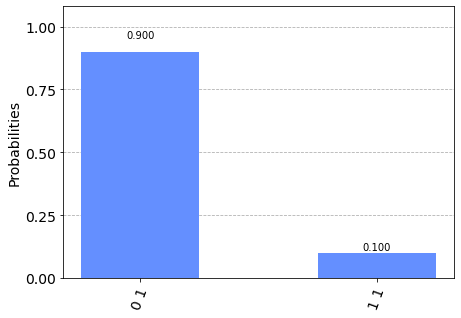

In [103]:
flag_is_0 = ' 0'
del counts['0' + flag_is_0]
del counts['1' + flag_is_0]
plot_histogram(counts)

**TODO**. 
- You measured shots. Shots divided by `total` is probability. But you need amplitudes.
- Reuse `naive_hhl_solution.euclidean_norm` to scale your soultion.

In [104]:
total = counts['0 1'] + counts['1 1']
print(total)

# TODO: reuse naive_hhl_solution.euclidean_norm

624784
1.1252124533701793 0.3743620370452378
